# Abstract

Get statistics for the scale ratios in inliers.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)
    
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m


def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2, np.ones_like(coordx2)])
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm((hypotheses @ pts1) - pts2, axis=1)


def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )


def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H


def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np

In [3]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: All variables and logger set up
ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [4]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [5]:
t0 = perf_counter()

# Get centroid ids, then centroids and then residual packs
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')

# ---
q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()

(t1 - t0)

7.102589750022162

In [6]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'

---

In [7]:
t0 = perf_counter()
#  =========================
MIN_INLIERS = 5

scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])
inlier_scale_ratios = []

for qi in range(70):  # query index
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

    for dbi in (gnd['gnd'][qi]['easy'] + gnd['gnd'][qi]['hard']):
        
        dbl = np.searchsorted(desc['imids'], dbi, 'left')
        dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        if not corrs.size:
            continue
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_mask = None
        total_A = None
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            mask = verifications[best_hypothesis_index]

            support = (mask * _similarities).sum()

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                new_mask = verify_models(errors, corrs)[0]
                new_support = (new_mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                    mask = new_mask
                else:
                    break
            
            if support > total_support:
                total_support = support
                total_A = A
                total_mask = mask
                
        # Save data to investigate
        if total_mask.sum() >= MIN_INLIERS:
            determinant = np.linalg.det(total_A)
            assert determinant != 0
            scale_ratios = np.sqrt(np.abs(determinant)) * scales1[total_mask] / scales2[total_mask]
            inlier_scale_ratios.extend(scale_ratios)
    
#  =========================
t1 = perf_counter()
t1 - t0

516.9814018749748

In [8]:
len(inlier_scale_ratios)

366743

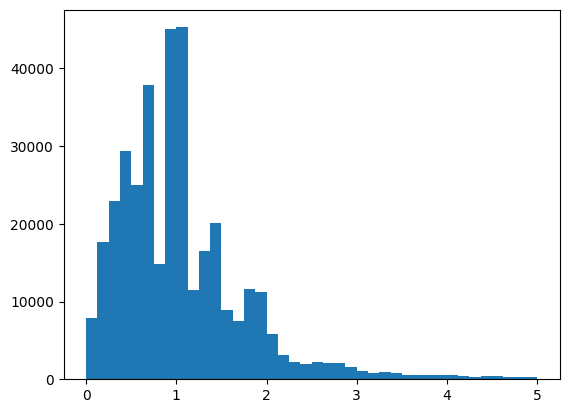

In [9]:
plt.hist(inlier_scale_ratios, range=(0, 5), bins=40)
plt.show()

---

In [10]:
metadata, images, ranks, _scores = asmk_dataset.query_ivf(desc['qvecs'], desc['qimids'])
compute_map_and_print(DATASET, ranks.T, gnd['gnd'])

>> roxford5k: mAP E: 94.75, M: 78.19, H: 55.51
>> roxford5k: mP@k[1, 5, 10] E: [100.    96.18  94.5 ], M: [100.    96.    92.86], H: [95.71 81.14 72.  ]


In [11]:
t0 = perf_counter()

incorrect_pairs = []

for qi in range(len(gnd['gnd'])):
    
    count_to_find = len(gnd['gnd'][qi]['easy']) + len(gnd['gnd'][qi]['hard'])
    incorrect_pairs_local = []
    
    for dbi in ranks[qi]:
    
        if dbi in gnd['gnd'][qi]['easy']:
            continue
        if dbi in gnd['gnd'][qi]['hard']:
            continue
        if dbi in gnd['gnd'][qi]['junk']:
            continue
            
        incorrect_pairs_local.append(dbi)
        
        if len(incorrect_pairs_local) == count_to_find:
            break
    
    incorrect_pairs.append(incorrect_pairs_local)
    
t1 = perf_counter()
t1 - t0

0.03399800002807751

In [12]:
t0 = perf_counter()
#  =========================
MIN_INLIERS = 5

scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])
outlier_scale_ratios = []

for qi in range(70):  # query index
    ql = np.searchsorted(desc['qimids'], qi, 'left')
    qr = np.searchsorted(desc['qimids'], qi, 'right')
    
    q_vecs = desc['qvecs'][ql:qr]
    q_centroid_ids = qvecs_centroid_ids[ql:qr]
    q_coordx = desc['qcoordx'][ql:qr]
    q_coordy = desc['qcoordy'][ql:qr]
    q_scales = desc['qscales'][ql:qr]
    q_residuals = q_residual_packs[ql:qr]

    # for dbi in (gnd['gnd'][qi]['easy'] + gnd['gnd'][qi]['hard']):
    for dbi in incorrect_pairs[i]:
        
        dbl = np.searchsorted(desc['imids'], dbi, 'left')
        dbr = np.searchsorted(desc['imids'], dbi, 'right')
        
        db_vecs = desc['vecs'][dbl:dbr]
        db_centroid_ids = dbvecs_centroid_ids[dbl:dbr]
        db_coordx = desc['coordx'][dbl:dbr]
        db_coordy = desc['coordy'][dbl:dbr]
        db_scales = desc['scales'][dbl:dbr]
        db_residuals = db_residual_packs[dbl:dbr]
        
        # Generate correspondences
        corrs, similarities = get_tentative_correspondencies(
            q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
        )
        _similarities = similarities * (similarities > 0)
        
        if not corrs.size:
            continue
        
        # Pick corresponding data
        scales1 = scales[q_scales[corrs[:, 0]]]
        coordx1 = q_coordx[corrs[:, 0]] * 16 / scales1
        coordy1 = q_coordy[corrs[:, 0]] * 16 / scales1

        scales2 = scales[db_scales[corrs[:, 1]]]
        coordx2 = db_coordx[corrs[:, 1]] * 16 / scales2
        coordy2 = db_coordy[corrs[:, 1]] * 16 / scales2
        
        # Generate hypotheses
        hypotheses = generate_hypotheses(
            coordx1,
            coordy1,
            scales1,
            coordx2,
            coordy2,
            scales2,
        )
        
        # Compute errors and verify models
        errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
        verifications = verify_models(errors, corrs)
        
        # Local optimization of the best model
        sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

        total_support = -1
        total_mask = None
        total_A = None
        
        for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
            A = hypotheses[best_hypothesis_index]
            mask = verifications[best_hypothesis_index]

            support = (mask * _similarities).sum()

            while True:
                new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
                errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
                new_mask = verify_models(errors, corrs)[0]
                new_support = (new_mask * _similarities).sum()

                if new_support > support:
                    support = new_support
                    A = new_A
                    mask = new_mask
                else:
                    break
            
            if support > total_support:
                total_support = support
                total_A = A
                total_mask = mask
                
        # Save data to investigate
        determinant = np.linalg.det(total_A)
        assert determinant != 0
        scale_ratios = np.sqrt(np.abs(determinant)) * scales1[total_mask] / scales2[total_mask]
        outlier_scale_ratios.extend(scale_ratios)
    
#  =========================
t1 = perf_counter()
t1 - t0

11.391073792008683

In [13]:
len(outlier_scale_ratios)

14420

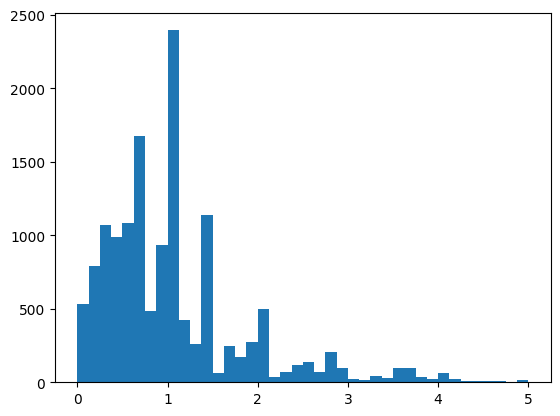

In [14]:
plt.hist(outlier_scale_ratios, range=(0, 5), bins=40)
plt.show()

---

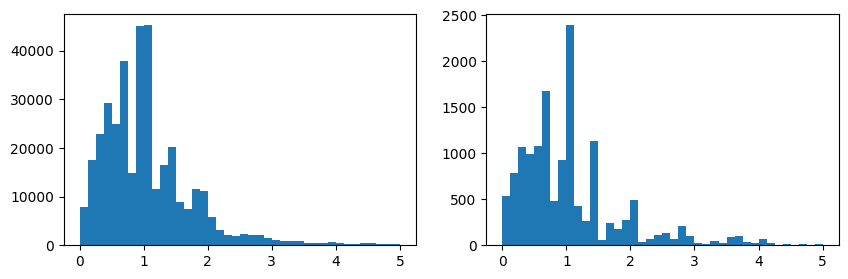

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].hist(inlier_scale_ratios, range=(0, 5), bins=40)
ax[1].hist(outlier_scale_ratios, range=(0, 5), bins=40)
plt.show()

---

In [28]:
max(inlier_scale_ratios), max(outlier_scale_ratios)

(25.46554924861352, 17.56739376878518)

In [50]:
N = 10
bins = [0]
bins.extend(1 / n for n in range(N, 0, -1))
bins.extend(range(2, N + 1))

In [51]:
bins

[0,
 0.1,
 0.1111111111111111,
 0.125,
 0.14285714285714285,
 0.16666666666666666,
 0.2,
 0.25,
 0.3333333333333333,
 0.5,
 1.0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10]

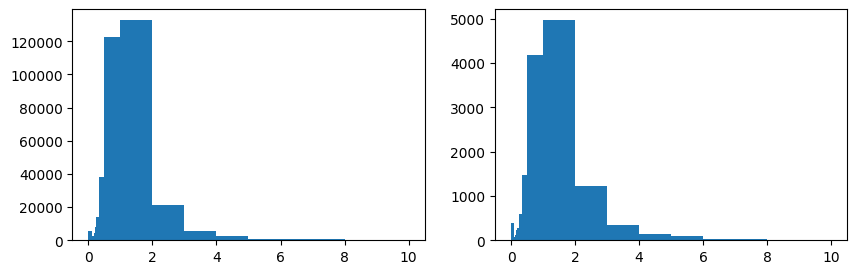

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].hist(inlier_scale_ratios, bins=bins)
ax[1].hist(outlier_scale_ratios, bins=bins)
plt.show()

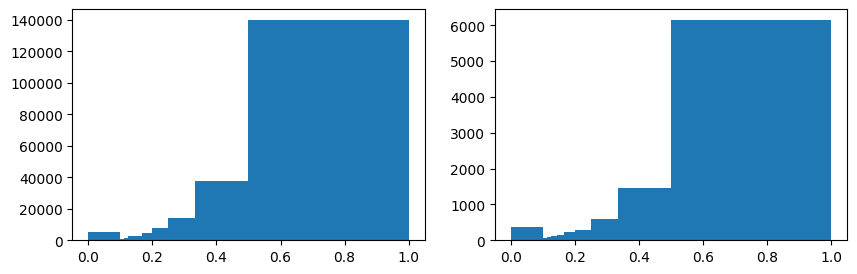

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].hist(inlier_scale_ratios, bins=bins[:N+1])
ax[1].hist(outlier_scale_ratios, bins=bins[:N+1])
plt.show()